In [11]:
pip install pandas openpyxl matplotlib seaborn fuzzywuzzy networkx scikit-learn

Note: you may need to restart the kernel to use updated packages.


In [12]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from itertools import combinations
import matplotlib.image as mpimg
import geopandas as gpd
from fuzzywuzzy import process
import networkx as nx
from collections import Counter 
import numpy as np 
from IPython.display import SVG, display

In [8]:
df = pd.read_excel('datasets/combined_output.xlsx', engine='openpyxl')

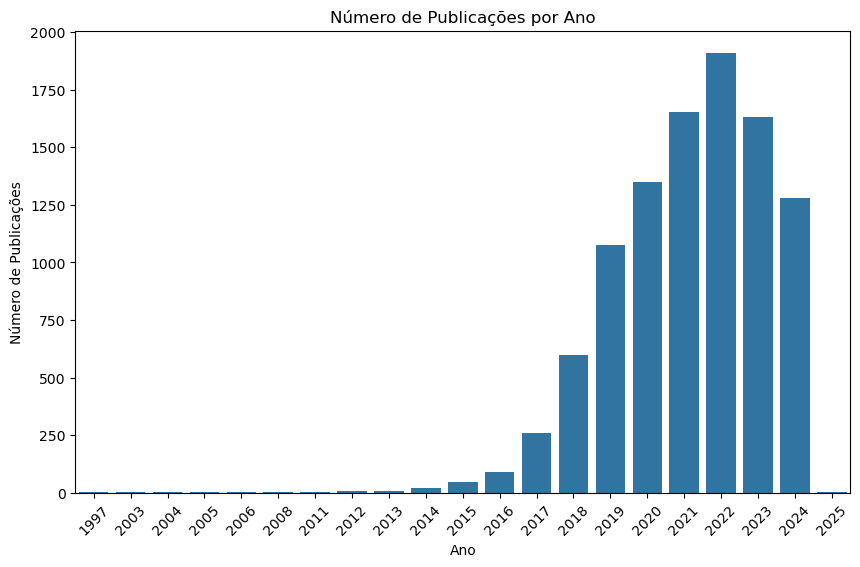

In [69]:
publicacoes_por_ano = df['Publication Year'].value_counts().sort_index()

plt.figure(figsize=(10, 6))
sns.barplot(x=publicacoes_por_ano.index, y=publicacoes_por_ano.values)
plt.title('Número de Publicações por Ano')
plt.xlabel('Ano')
plt.ylabel('Número de Publicações')
plt.xticks(rotation=45)
plt.show()

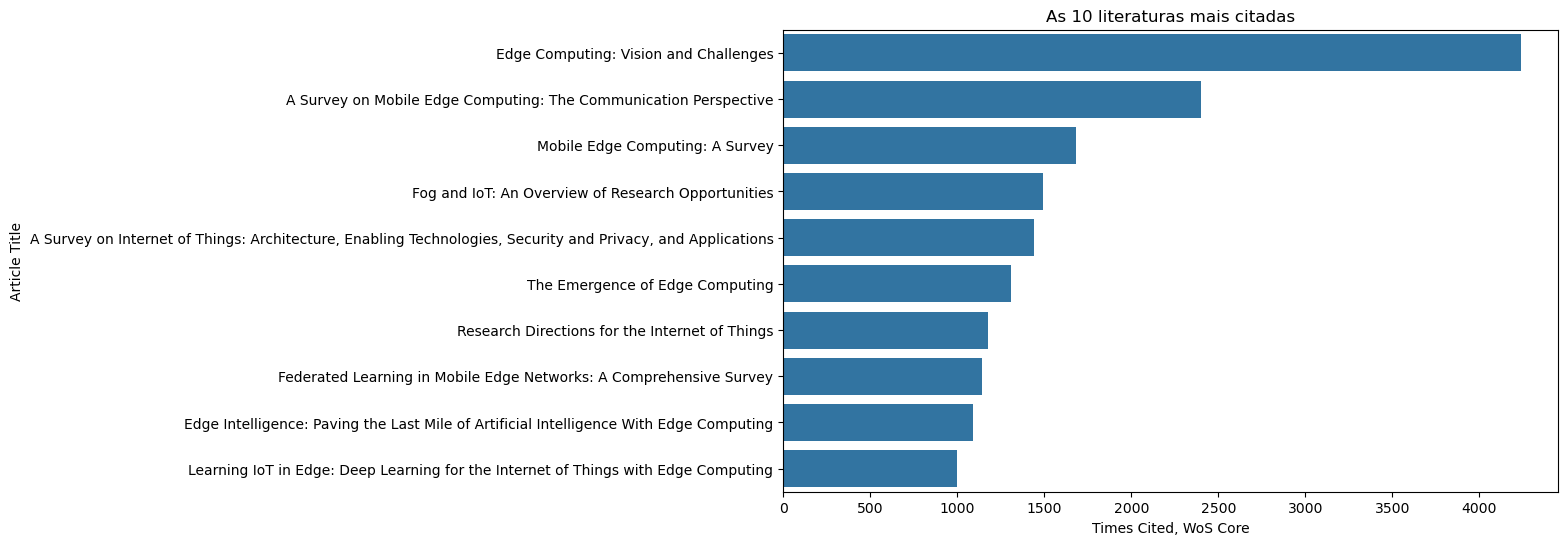

In [28]:
# 1. As 10 literaturas mais citadas

literature_data = df[['Article Title', 'Times Cited, WoS Core']].sort_values('Times Cited, WoS Core', ascending=False).head(10)
plt.figure(figsize=(10,6))
sns.barplot(x='Times Cited, WoS Core', y='Article Title', data=literature_data)
plt.title('As 10 literaturas mais citadas')
plt.show() 

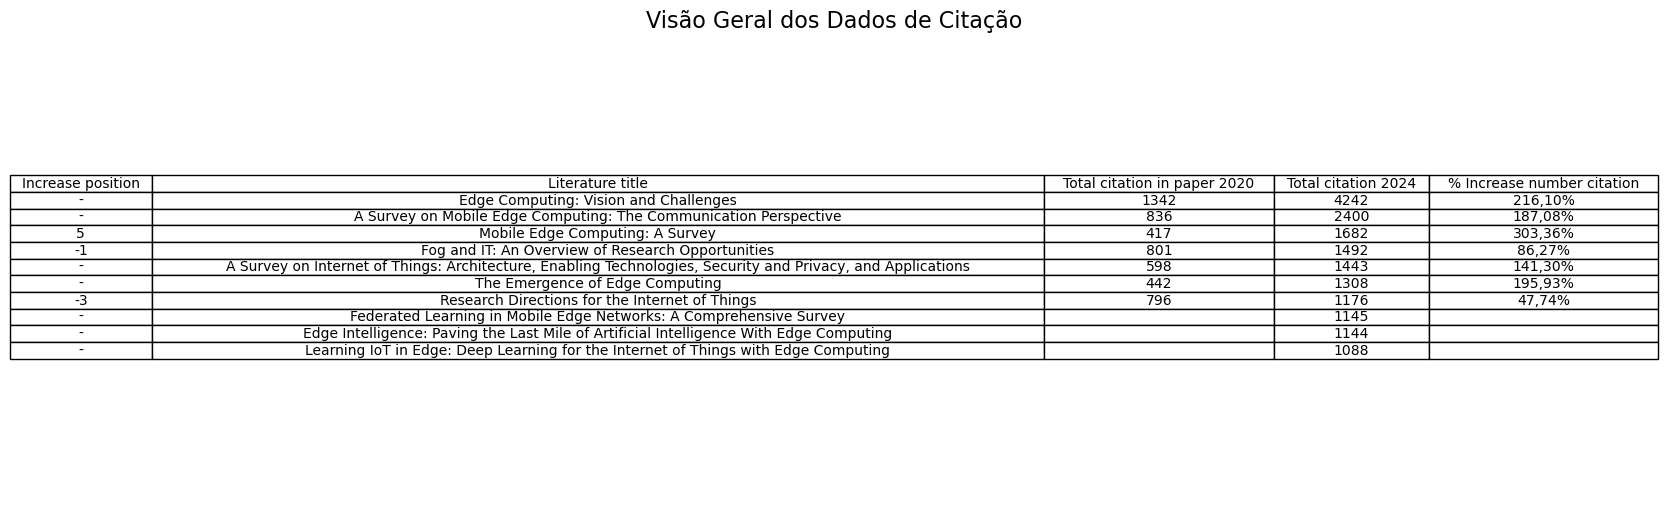

In [37]:
data = {
    'Increase position': ['-', '-', 5, -1, '-', '-', -3, '-', '-', '-'],
    'Literature title': [
        'Edge Computing: Vision and Challenges',
        'A Survey on Mobile Edge Computing: The Communication Perspective',
        'Mobile Edge Computing: A Survey',
        'Fog and IT: An Overview of Research Opportunities',
        'A Survey on Internet of Things: Architecture, Enabling Technologies, Security and Privacy, and Applications',
        'The Emergence of Edge Computing',
        'Research Directions for the Internet of Things',
        'Federated Learning in Mobile Edge Networks: A Comprehensive Survey',
        'Edge Intelligence: Paving the Last Mile of Artificial Intelligence With Edge Computing',
        'Learning IoT in Edge: Deep Learning for the Internet of Things with Edge Computing'
    ],
    'Total citation in paper 2020': [1342, 836, 417, 801, 598, 442, 796, None, None, None],  
    'Total citation 2024': [4242, 2400, 1682, 1492, 1443, 1308, 1176, 1145, 1144, 1088],
    '% Increase number citation': ['216,10%', '187,08%', '303,36%', '86,27%', '141,30%', '195,93%', '47,74%', None, None, None]
}

tmp_table = pd.DataFrame(data)

tmp_table['Total citation in paper 2020'] = tmp_table['Total citation in paper 2020'].fillna('').apply(lambda x: f'{int(x)}' if x != '' else '')
tmp_table['Total citation 2024'] = tmp_table['Total citation 2024'].astype(int).astype(str)

fig, ax = plt.subplots(figsize=(12, 6)) 
ax.axis('tight')
ax.axis('off')

the_table = ax.table(cellText=tmp_table.values, colLabels=tmp_table.columns, cellLoc='center', loc='center')

the_table.auto_set_font_size(False)
the_table.set_fontsize(10)

for i, column in enumerate(tmp_table.columns):
    max_length = max(tmp_table[column].astype(str).map(len).max(), len(column)) 
    the_table.auto_set_column_width([i])  
    the_table[i, 0].set_width(max_length * 0.015) 

plt.title('Visão Geral dos Dados de Citação', fontsize=16)   

plt.show()


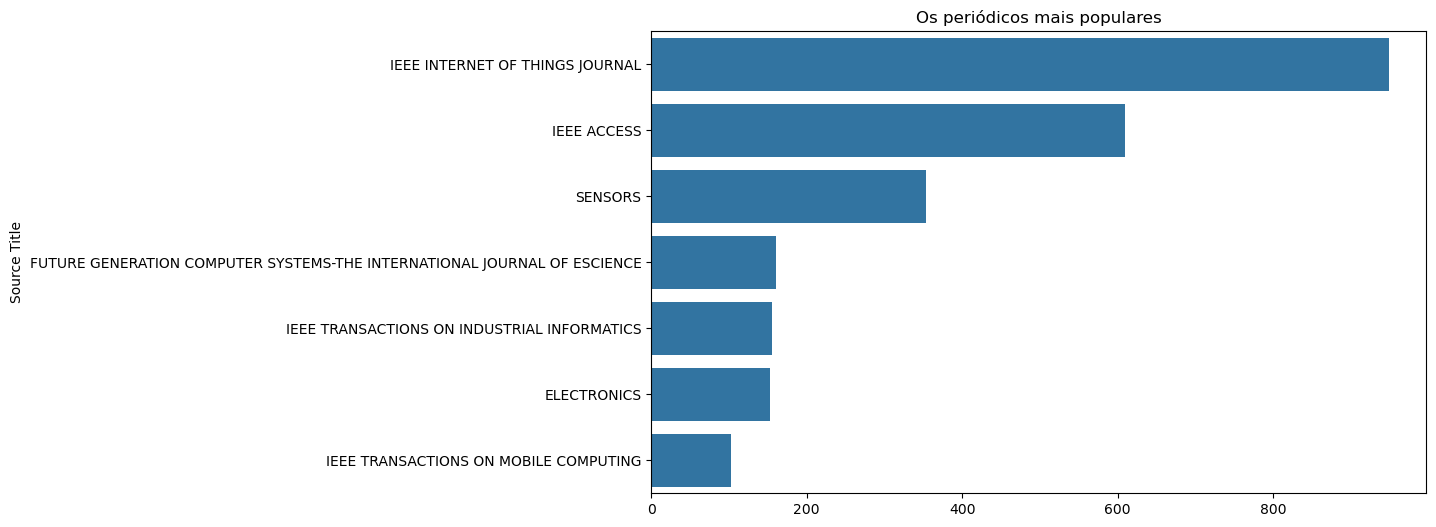

In [72]:
# 2. Os periódicos mais populares

journal_data = df['Source Title'].value_counts().head(7)
plt.figure(figsize=(10,6))
sns.barplot(x=journal_data.values, y=journal_data.index)
plt.title('Os periódicos mais populares')
plt.show() 

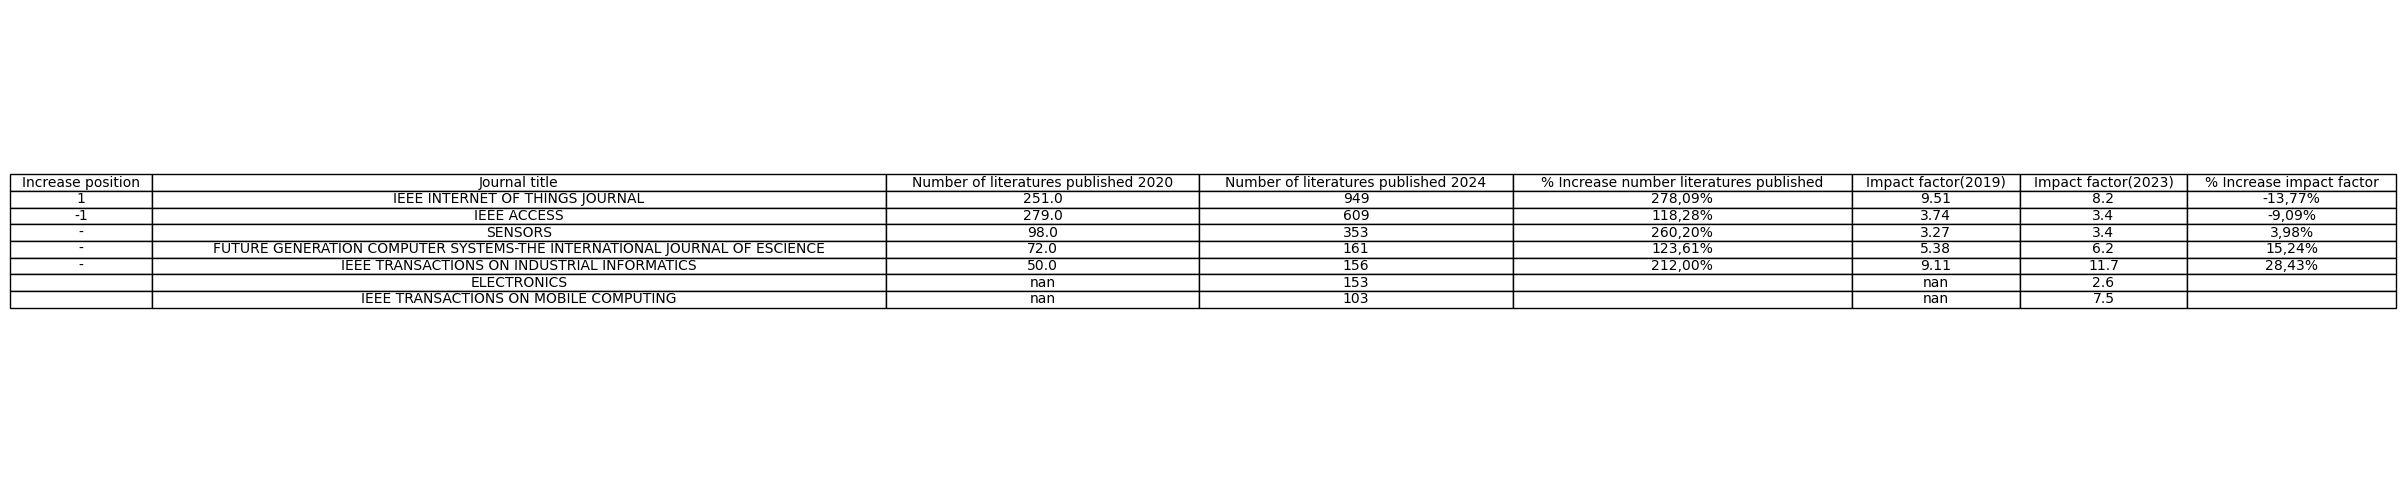

In [23]:

data = {
    'Increase position': [1, -1, '-', '-', '-', '', ''],
    'Journal title': [
        'IEEE INTERNET OF THINGS JOURNAL',
        'IEEE ACCESS',
        'SENSORS',
        'FUTURE GENERATION COMPUTER SYSTEMS-THE INTERNATIONAL JOURNAL OF ESCIENCE',
        'IEEE TRANSACTIONS ON INDUSTRIAL INFORMATICS',
        'ELECTRONICS',
        'IEEE TRANSACTIONS ON MOBILE COMPUTING'
    ],
    'Number of literatures published 2020': [251, 279, 98, 72, 50, None, None],
    'Number of literatures published 2024': [949, 609, 353, 161, 156, 153, 103],
    '% Increase number literatures published': ['278,09%', '118,28%', '260,20%', '123,61%', '212,00%', None, None],
    'Impact factor(2019)': [9.51, 3.74, 3.27, 5.38, 9.11, None, None],
    'Impact factor(2023)': [8.2, 3.4, 3.4, 6.2, 11.7, 2.6, 7.5],
    '% Increase impact factor': ['-13,77%', '-9,09%', '3,98%', '15,24%', '28,43%', None, None]
}

tmp_table = pd.DataFrame(data)

fig, ax = plt.subplots(figsize=(12, 6)) 
ax.axis('tight')
ax.axis('off')

the_table = ax.table(cellText=tmp_table.values, colLabels=tmp_table.columns, cellLoc='center', loc='center')

the_table.auto_set_font_size(False)
the_table.set_fontsize(10)

for i, column in enumerate(tmp_table.columns):
    max_length = max(tmp_table[column].astype(str).map(len).max(), len(column)) 
    the_table.auto_set_column_width([i])  
    the_table[i, 0].set_width(max_length * 0.015) 

plt.show()


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


       Author  Publication Count
0    Zhang, Y                 85
1     Chen, Y                 77
2     Wang, J                 69
3     Chen, X                 64
4    Zhang, J                 61
5  Guizani, M                 61
6       Li, J                 59
7     Wang, Y                 56
8      Liu, Y                 55
9       Wu, J                 52


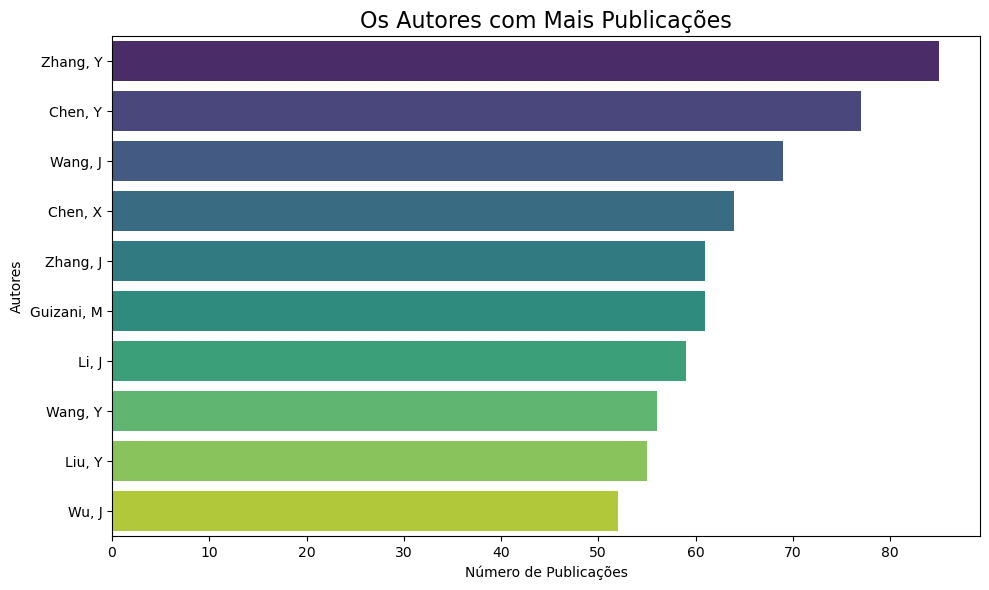

In [74]:
df_temp = df.copy()

df_temp['Authors'] = df_temp['Authors'].str.split('; ')
df_temp = df_temp.explode('Authors')

df_unique = df_temp.drop_duplicates(subset=['Authors', 'Article Title'])

author_data = df_unique['Authors'].value_counts().head(10)

author_df = author_data.reset_index()
author_df.columns = ['Author', 'Publication Count']

print(author_df)

plt.figure(figsize=(10, 6))
sns.barplot(x='Publication Count', y='Author', data=author_df, hue='Author', palette='viridis', dodge=False)
plt.title('Os Autores com Mais Publicações', fontsize=16)
plt.xlabel('Número de Publicações')
plt.ylabel('Autores')
plt.legend().set_visible(False) 
plt.tight_layout()
plt.show()

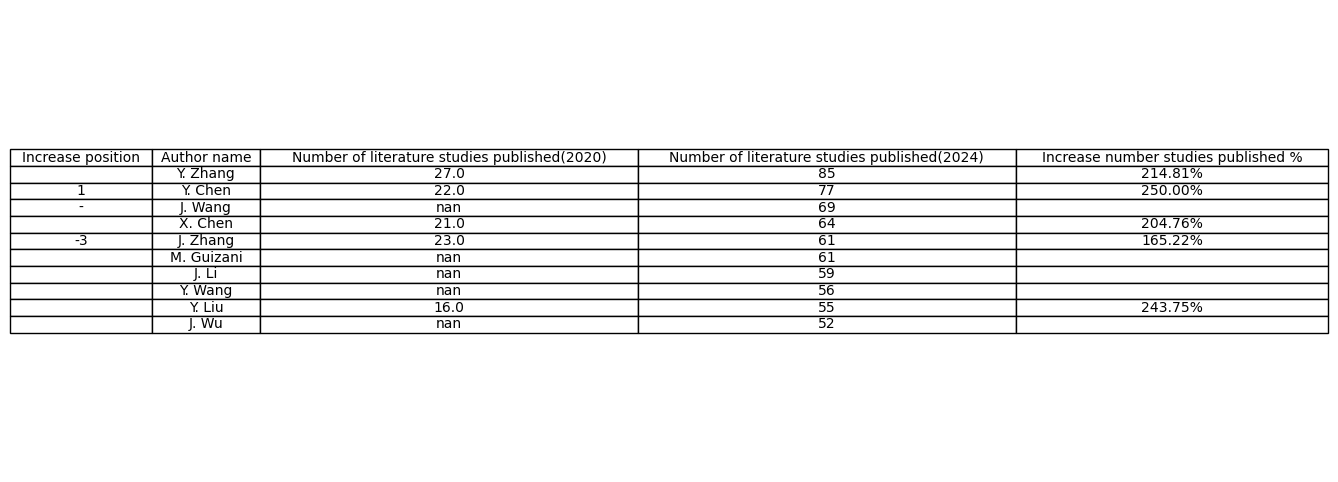

In [22]:
data = {
    'Increase position': ['', '1', '-', '', '-3', '', '', '', '', ''],
    'Author name': [
        'Y. Zhang', 
        'Y. Chen', 
        'J. Wang', 
        'X. Chen', 
        'J. Zhang', 
        'M. Guizani', 
        'J. Li', 
        'Y. Wang', 
        'Y. Liu',
        'J. Wu'
    ],
    'Number of literature studies published(2020)': [27, 22, 0, 21, 23, 0, 0, 0, 16, 0],
    'Number of literature studies published(2024)': [85, 77, 69, 64, 61, 61, 59, 56, 55, 52],
    'Increase number studies published %': ['214.81%', '250.00%', None, '204.76%', '165.22%', None, None, None, '243.75%', None]
}

data['Number of literature studies published(2020)'] = [
    np.nan if x == 0 else x for x in data['Number of literature studies published(2020)']
]
data['Number of literature studies published(2024)'] = [
    np.nan if x == 0 else x for x in data['Number of literature studies published(2024)']
]

max_length = max(len(data['Increase position']),
                 len(data['Author name']),
                 len(data['Number of literature studies published(2020)']),
                 len(data['Number of literature studies published(2024)']),
                 len(data['Increase number studies published %']))

for key in data.keys():
    while len(data[key]) < max_length:
        data[key].append(None)

tmp_table = pd.DataFrame(data)

fig, ax = plt.subplots(figsize=(12, 6)) 
ax.axis('tight')
ax.axis('off')

the_table = ax.table(cellText=tmp_table.values, colLabels=tmp_table.columns, cellLoc='center', loc='center')

the_table.auto_set_font_size(False)
the_table.set_fontsize(10)

for i, column in enumerate(tmp_table.columns):
    max_length = max(tmp_table[column].astype(str).map(len).max(), len(column)) 
    the_table.auto_set_column_width([i])  
    the_table[i, 0].set_width(max_length * 0.015) 

plt.show()


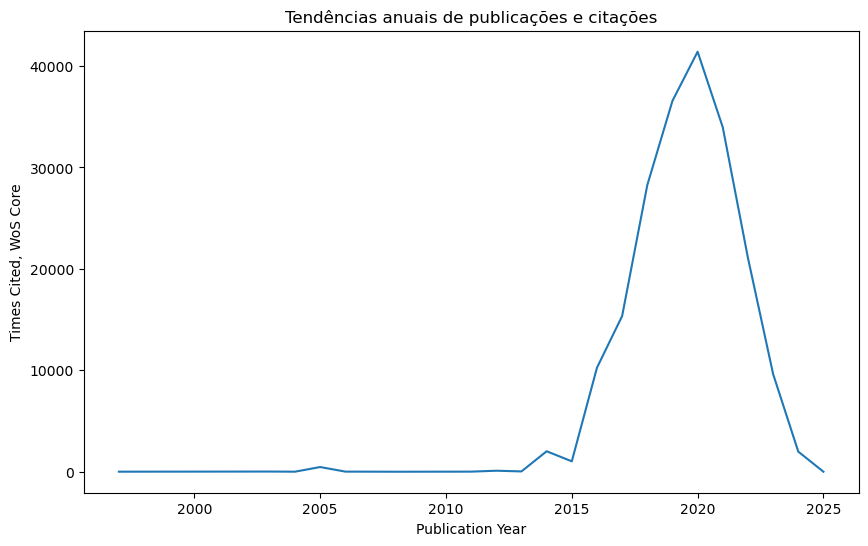

In [76]:
# 4. Tendências anuais de publicações e citações
yearly_trend = df.groupby('Publication Year')['Times Cited, WoS Core'].sum().reset_index()
plt.figure(figsize=(10,6))
sns.lineplot(x='Publication Year', y='Times Cited, WoS Core', data=yearly_trend)
plt.title('Tendências anuais de publicações e citações')
plt.show() 

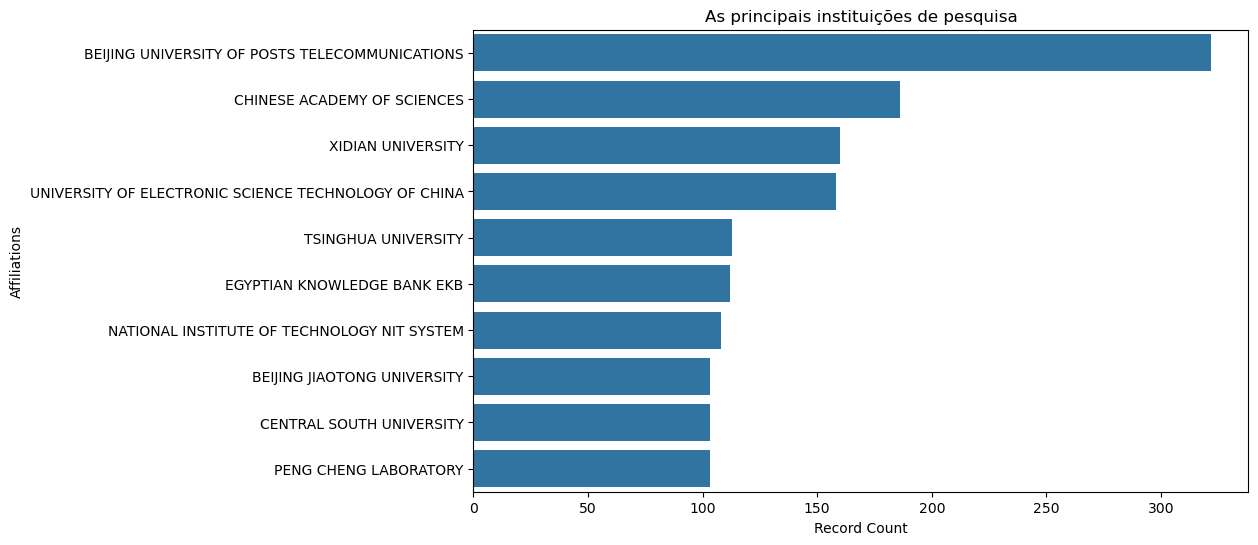

In [6]:
#RQ5: Quais são as principais instituições de pesquisa em EC-IoT?

top_institutions = df_temp[['Affiliations', 'Record Count']].nlargest(10, 'Record Count')
 
# Criar o gráfico de barras
plt.figure(figsize=(10,6))
sns.barplot(x=top_institutions['Record Count'], y=top_institutions['Affiliations'])
plt.title('As principais instituições de pesquisa')
plt.xlabel('Record Count')
plt.ylabel('Affiliations')
plt.show()

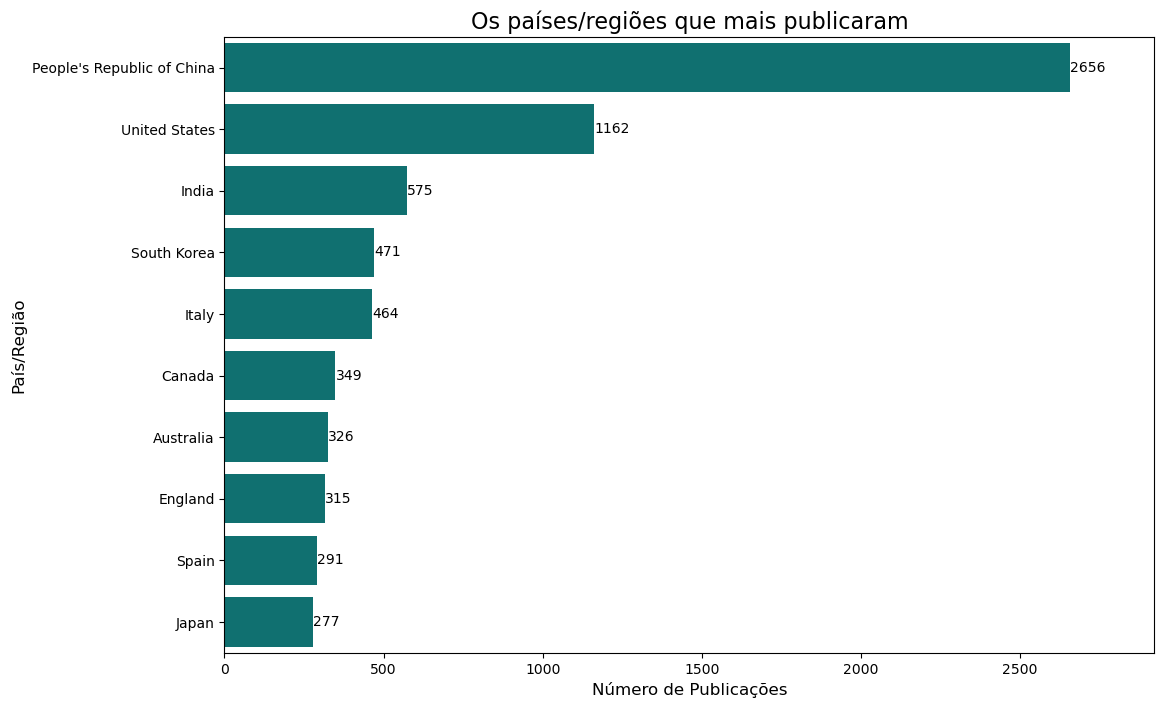

In [5]:
def clean_country_name(name):
    name = name.strip()
    if 'USA' in name:
        return 'United States'
    if 'R China' in name:
        return 'People\'s Republic of China'
    return name

countries_data = df['Addresses'].fillna('').apply(lambda x: str(x).split(',')[-1].strip())
countries_data = countries_data.map(clean_country_name).value_counts().head(10)

plt.figure(figsize=(12, 8))

sns.barplot(x=countries_data.values, y=countries_data.index, color='teal')  

plt.title('Os países/regiões que mais publicaram', fontsize=16)
plt.xlabel('Número de Publicações', fontsize=12)
plt.ylabel('País/Região', fontsize=12)

for index, value in enumerate(countries_data.values):
    plt.text(value, index, f'{value}', va='center')

plt.xlim(0, countries_data.max() * 1.1) 
plt.show()


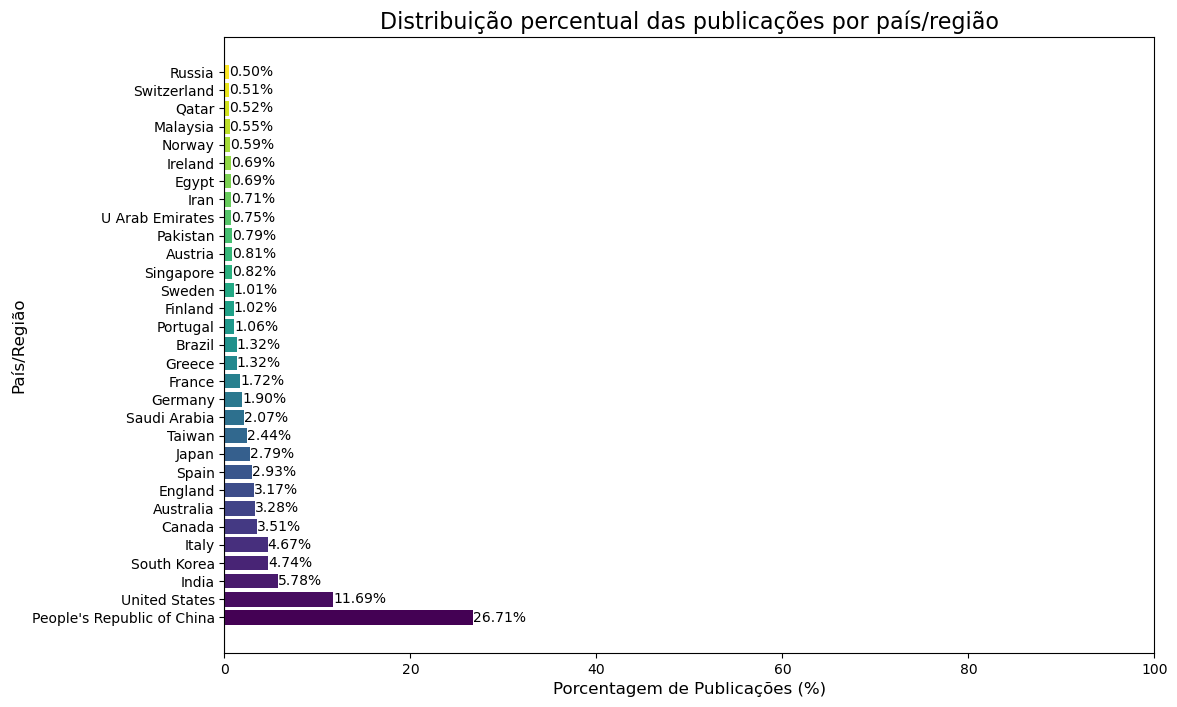

In [17]:
countries_data = df['Addresses'].fillna('').apply(lambda x: str(x).split(',')[-1].strip()).value_counts()

countries_data.index = countries_data.index.map(clean_country_name)

countries_data = countries_data.groupby(countries_data.index).sum()

total_publications = countries_data.sum()
countries_percentage = (countries_data / total_publications) * 100

countries_percentage = countries_percentage[countries_percentage > 0.5]

countries_percentage = countries_percentage.sort_values(ascending=False)

plt.figure(figsize=(12, 8))
colors = plt.cm.viridis(np.linspace(0, 1, len(countries_percentage))) 
bars = plt.barh(countries_percentage.index, countries_percentage.values, color=colors)

for bar in bars:
    width = bar.get_width()
    plt.text(width, bar.get_y() + bar.get_height() / 2, f'{width:.2f}%', va='center')

plt.title('Distribuição percentual das publicações por país/região', fontsize=16)
plt.xlabel('Porcentagem de Publicações (%)', fontsize=12)
plt.ylabel('País/Região', fontsize=12)
plt.xlim(0, 100)  
plt.axvline(0, color='grey', linewidth=0.8) 
plt.show()


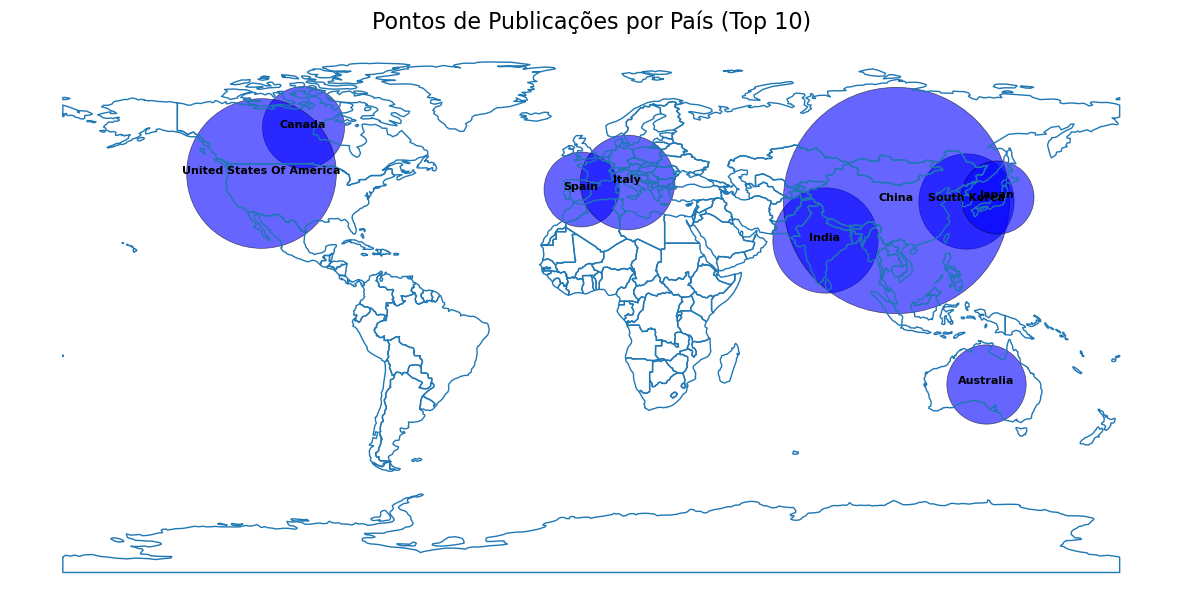

In [16]:

 

world = gpd.read_file('datasets/map/ne_110m_admin_0_countries.shp')

countries_data = df['Addresses'].fillna('').apply(lambda x: str(x).split(',')[-1].strip())
countries_data = countries_data.map(clean_country_name).value_counts()

countries_df = pd.DataFrame(countries_data).reset_index()
countries_df.columns = ['Country', 'Publication Count']

top_countries_df = countries_df.nlargest(10, 'Publication Count')

world['ADMIN'] = world['ADMIN'].str.strip().str.title()

def get_best_match(country_name, choices):
    if not country_name:  
        return None
    match, score = process.extractOne(country_name, choices)
    return match if score >= 80 else None  

geo_countries = world['ADMIN'].unique()

top_countries_df['Country'] = top_countries_df['Country'].apply(lambda x: get_best_match(x, geo_countries))

top_countries_df = top_countries_df.dropna(subset=['Country'])

merged = world.merge(top_countries_df, how="left", left_on="ADMIN", right_on="Country")

fig, ax = plt.subplots(1, 1, figsize=(15, 10))

world.boundary.plot(ax=ax, linewidth=1)

for idx, row in merged.iterrows():
    if row['Publication Count'] > 0:
        ax.scatter(*row.geometry.centroid.coords[0], 
                   s=row['Publication Count'] * 10, 
                   alpha=0.6, color='blue', edgecolor='k', linewidth=0.5)
        ax.annotate(text=row['Country'], 
                    xy=row.geometry.centroid.coords[0], 
                    ha='center', fontsize=8, color='black', weight='bold')

plt.title('Pontos de Publicações por País (Top 10)', fontsize=16)
plt.axis('off') 
plt.show()


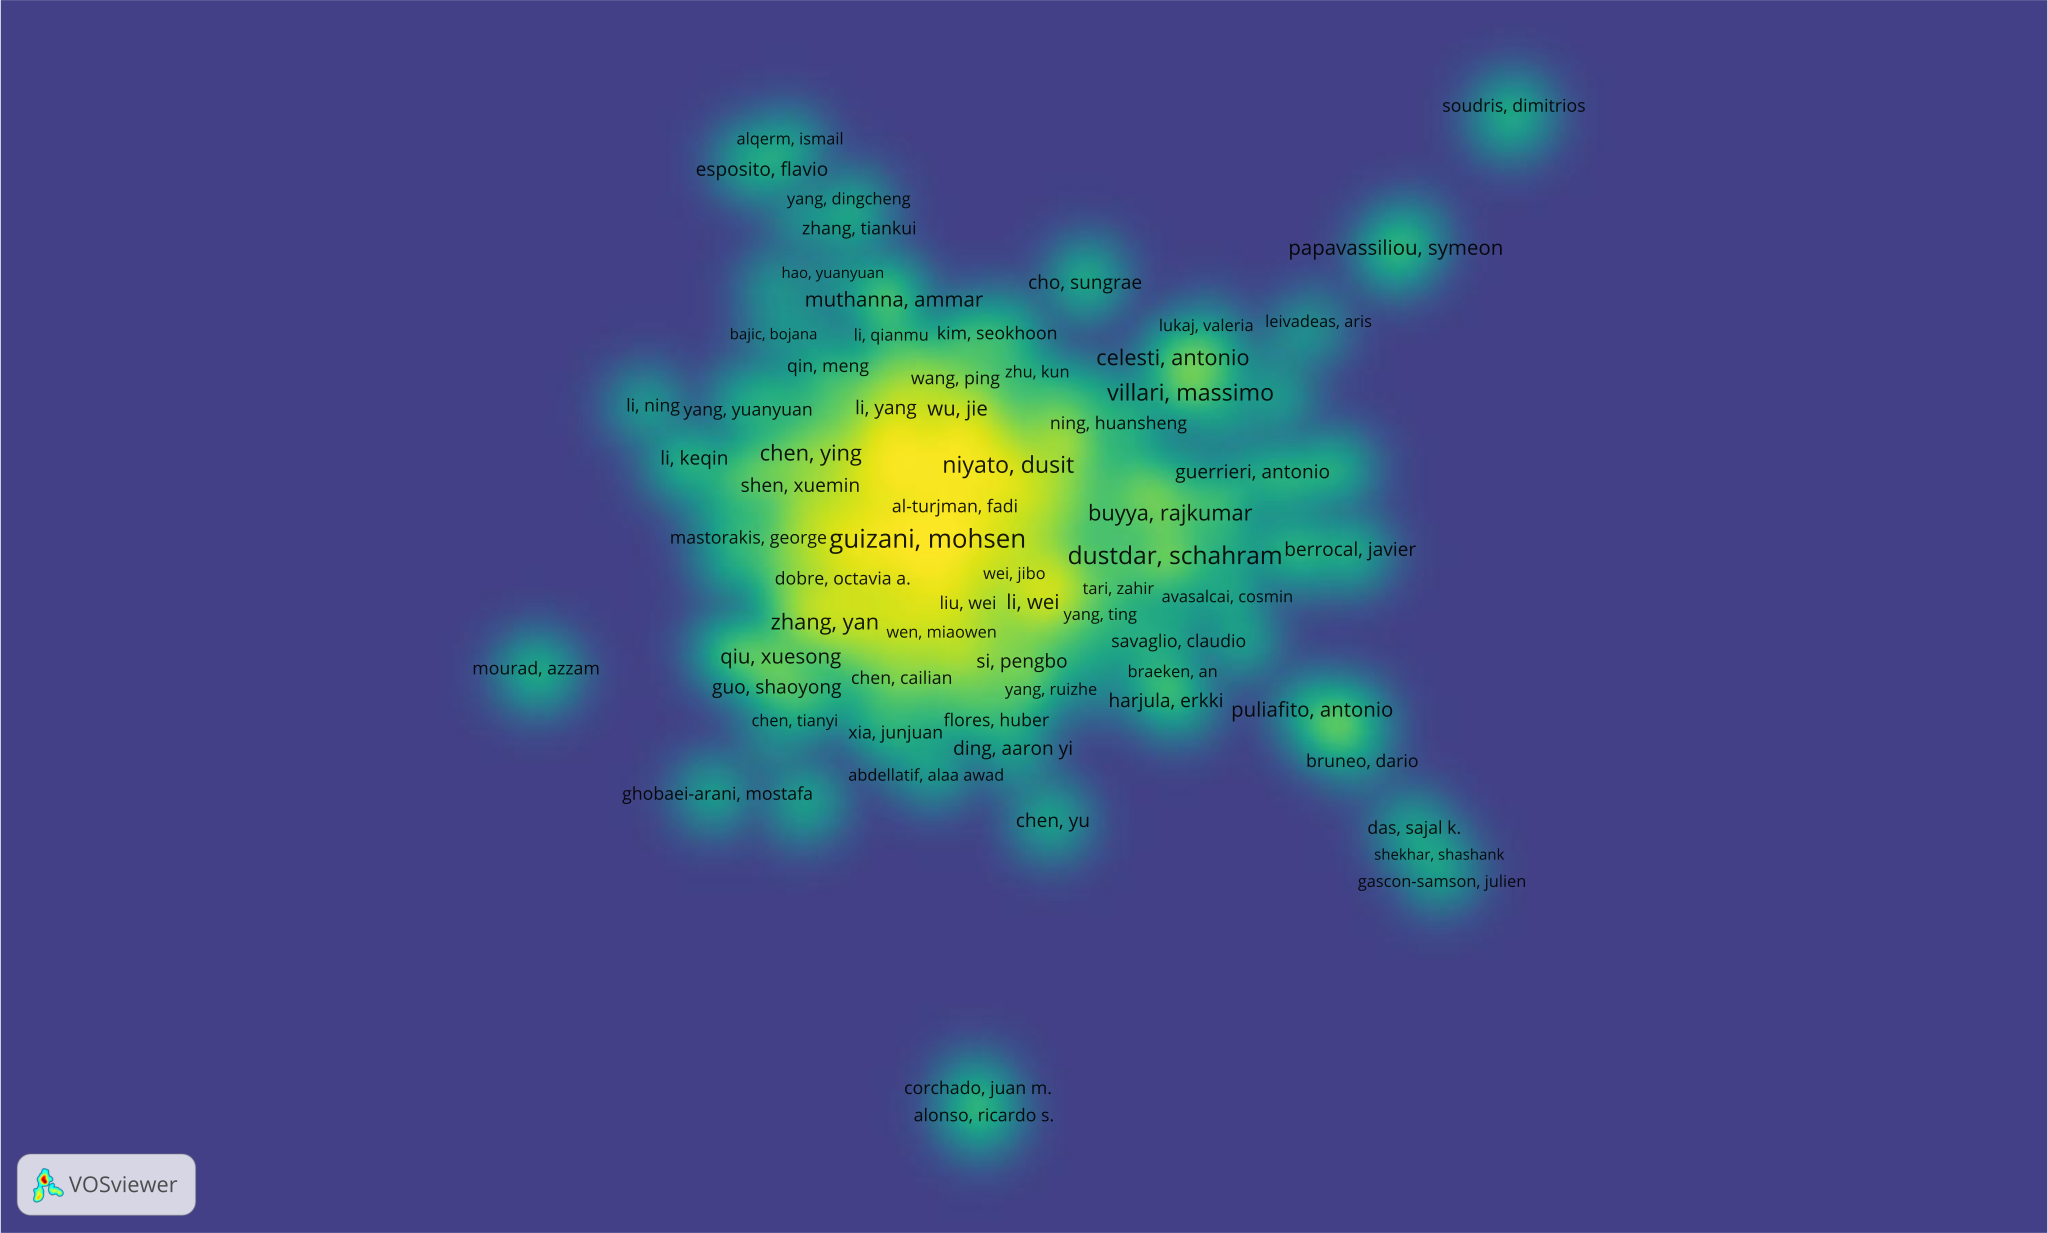

In [16]:
#Mapa de calor de co-authors
file_path = "imgs/co-author-density.svg"
display(SVG(filename=file_path))

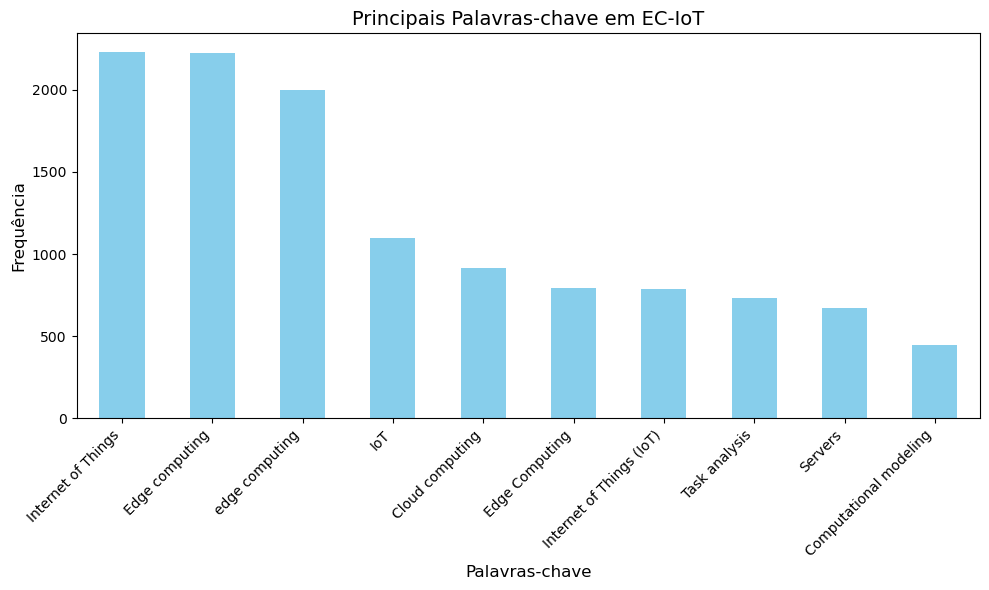

In [25]:
df_temp = df['Author Keywords'].dropna()

df_temp = df_temp.str.split(';')

df_keywords = df_temp.explode()

df_keywords = df_keywords.str.strip()

keyword_counts = df_keywords.value_counts()

top_keywords = keyword_counts.index.tolist()[:10] 

plt.figure(figsize=(10, 6))
keyword_counts.head(10).plot(kind='bar', color='skyblue')

plt.title('Principais Palavras-chave em EC-IoT', fontsize=14)
plt.xlabel('Palavras-chave', fontsize=12)
plt.ylabel('Frequência', fontsize=12)

plt.xticks(rotation=45, ha='right')

plt.tight_layout()
plt.show()
